In [1]:
import pandas as pd
from pyspark.sql.functions import (col, rand, udf, collect_set, collect_list, concat, array_distinct, flatten, when, length)
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType, FloatType
from unidecode import unidecode
import re
from functools import reduce
import numpy as np
import tensorflow as tf
import keras
from fuzzywuzzy import fuzz

from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, GlobalMaxPooling1D, Layer, Masking, Lambda, Permute
import os
import pickle
from keras.layers import Bidirectional
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import functools
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, concatenate
from keras.activations import relu
from sklearn.model_selection import train_test_split


2023-08-22 16:26:39.474786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 16:26:39.585888: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[08/22/23 16:26:41] WARNING  /usr/local/lib/python3.9/dist-packages/fuzzywuzzy/fuzz.py:11:          ]8;id=146225;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=948644;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             UserWarning: Using slow pure-python SequenceMatcher. Install                          
                             python-Levenshtein to remove this warning                                             
                               warnings.warn('Using slow pure-python SequenceMatcher. Install                      
                             python-Levenshtein to remove this warning')                                           
                                                                                                                   

In [2]:
#env: geoNames

In [3]:
geonames_pairs = catalog.load('geonames_latin_pairs')
geonames_pairs = geonames_pairs.withColumn('target', when(col('match') == 'true', 1).otherwise(0).cast(FloatType()))

                    INFO     Loading data from 'geonames_latin_pairs' (SparkDataSet)...         ]8;id=79126;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=10006;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

In [4]:
geonames_pairs.groupBy('language_1').count().orderBy(col('count').desc()).limit(200).show()

+----------+------+
|language_1| count|
+----------+------+
|        CN|503487|
|        IR|282669|
|        RU|234588|
|        TH|174396|
|        AF|171604|
|        NO|109708|
|        KR|104579|
|        TW| 85863|
|        JP| 81481|
|        IQ| 59890|
|        FR| 58277|
|        PK| 55530|
|        TR| 49718|
|        SE| 47650|
|        EG| 47493|
|        SY| 45737|
|        GR| 41502|
|        YE| 40943|
|        UA| 39231|
|        MX| 37547|
+----------+------+
only showing top 20 rows



In [5]:
geonames_pairs.filter(col('language_1') == 'NL').limit(10).show()

+----------------+----------------+-------+-------+----------+----------+----------+----------+-----+------+
|          name_1|          name_2|   id_1|   id_2|alphabet_1|alphabet_2|language_1|language_2|match|target|
+----------------+----------------+-------+-------+----------+----------+----------+----------+-----+------+
|     Homsterland| Hultensche Leij|2753420|2753428|     LATIN|     LATIN|        NL|        NL|false|   0.0|
|       Wormingen|  Wormer en Jisp|2744170|2744172|     LATIN|     LATIN|        NL|        NL|false|   0.0|
|         De Neer|     Neyderveyrt|2750455|2750467|     LATIN|     LATIN|        NL|        NL|false|   0.0|
|     Spykerbosch|          Spronk|2746879|2746889|     LATIN|     LATIN|        NL|        NL|false|   0.0|
|    Sint Pancras|Sint Odilienberg|2747225|2747229|     LATIN|     LATIN|        NL|        NL|false|   0.0|
|Huis Voorstonden|          Voorst|2745279|2745297|     LATIN|     LATIN|        NL|        NL|false|   0.0|
|        Terheden| 

In [6]:
geonames_pairs_es = geonames_pairs.filter((col('language_1') == col('language_2')) & (col('language_1').isin(['ES', 'MX', 'AR', 'VE', 'FR', 'IT', 'GB', 'US', 'BR', 'DE', 'NL'])))

In [7]:
geonames_pairs_es.count()

195568

In [8]:
geonames_pairs_es.orderBy(rand()).show(100)

+--------------------+--------------------+-------+-------+----------+----------+----------+----------+-----+------+
|              name_1|              name_2|   id_1|   id_2|alphabet_1|alphabet_2|language_1|language_2|match|target|
+--------------------+--------------------+-------+-------+----------+----------+----------+----------+-----+------+
|           El Carmen| San Nicolás Hidalgo|4022734|4022735|     LATIN|     LATIN|        MX|        MX|false|   0.0|
|Sainte-Catherine-...|Sainte-Catherine-...|2980720|2980720|     LATIN|     LATIN|        FR|        FR| true|   1.0|
|         Sao Vicente|Ribeirão São Vicente|3448120|3448125|     LATIN|     LATIN|        BR|        BR|false|   0.0|
|           Tabatinga|Forte de São Fran...|6319345|6319345|     LATIN|     LATIN|        BR|        BR| true|   1.0|
|       mi tai er wei|         Mittelweier|2993670|2993670|     LATIN|     LATIN|        FR|        FR| true|   1.0|
|        Nije Biltsyl|   Nieuwe-Biltpollen|2750348|2750349|     

# 2. Function to normalize names

Requirements:

* Transform to unicode characters (utf-8)
* remove whitespaces

In [9]:
def normalize_characters(text: str) -> str:
    
    if text is None:
        return ''

    strange_char_space = r"!#$%&()*+,./:;<=>?@[\]^_{|}~ºª®-"
    char_2_remove = "\"'^`"
    space_mask = "                                "
    punctuation_table = str.maketrans(strange_char_space, space_mask,
                                        char_2_remove)
    text = text.lower()
    text = text.strip()
    text = unidecode(text)
    text = text.translate(punctuation_table)
    text = re.sub(r' +', ' ', text)
    text = text.strip()
    text = text.lower()

    return text

udf_normalize_chars = udf(normalize_characters)

In [10]:
geonames_normalized = geonames_pairs_es.withColumn('name_1_normalized', udf_normalize_chars(col('name_1'))) \
                .withColumn('name_2_normalized', udf_normalize_chars(col('name_2')))

# 3. Function to generate vocabulary

In [11]:
def get_unique_characters(string: str) -> list:

    unique_characters = list(set(string))
    return unique_characters

udf_get_unique_characters = udf(get_unique_characters, ArrayType(StringType()))


def compute_max_word_len(string: str) -> int:
    return max([len(word) for word in string.split(' ')])

udf_compute_max_word_len = udf(compute_max_word_len)

def compute_token_count(string: str) -> int:
    return len([word for word in string.split(' ')])

udf_compute_token_count = udf(compute_token_count)

In [12]:
geonames_characters = geonames_normalized.withColumn('unique_characters_1', udf_get_unique_characters(col('name_1_normalized'))) \
                                        .withColumn('unique_characters_2', udf_get_unique_characters(col('name_2_normalized'))) \
                                        .withColumn('unique_characters', array_distinct(concat(col('unique_characters_1'), col('unique_characters_2')))) \
                                        .withColumn('max_word_len_1', udf_compute_max_word_len(col('name_1_normalized')).cast(FloatType())) \
                                        .withColumn('max_word_len_2', udf_compute_max_word_len(col('name_2_normalized')).cast(FloatType())) \
                                        .withColumn('max_token_num_1', udf_compute_token_count(col('name_1_normalized')).cast(FloatType())) \
                                        .withColumn('max_token_num_2', udf_compute_token_count(col('name_2_normalized')).cast(FloatType())) \
                                        .withColumn('max_len_1', length(col('name_1_normalized')).cast(FloatType())) \
                                        .withColumn('max_len_2', length(col('name_2_normalized')).cast(FloatType()))

In [13]:
geonames_char_list = geonames_characters.groupBy().agg(
    array_distinct(flatten(collect_set(col('unique_characters')))).alias('char_list'),
    F.max(col('max_word_len_1')).alias('max_len_1'),
    F.max(col('max_word_len_2')).alias('max_len_2'),
    F.max(col('max_token_num_2')).alias('max_num_2'),
    F.max(col('max_token_num_1')).alias('max_num_1'),
    F.max(col('max_len_1')).alias('max_len_1'),
    F.max(col('max_len_2')).alias('max_len_1')
)

In [14]:
geonames_char_list.show()

+--------------------+---------+---------+---------+---------+---------+---------+
|           char_list|max_len_1|max_len_2|max_num_2|max_num_1|max_len_1|max_len_1|
+--------------------+---------+---------+---------+---------+---------+---------+
|[n, o, r, a, i, t...|     27.0|     58.0|     18.0|     16.0|     96.0|    111.0|
+--------------------+---------+---------+---------+---------+---------+---------+



In [15]:
characters_list = geonames_char_list.rdd.map(lambda x: x.char_list).collect()[0]
sorted_char_list = sorted(characters_list)

# 4. One Hot encoder

In [16]:
char_to_index = {char: index+1 for index, char in enumerate(sorted_char_list)}
index_to_char = {index: char for char, index in char_to_index.items()}
MAX_WORD_LENGTH = 16
MAX_TOKEN_NUMBER = 8
MAX_NAME_LEN = 100

In [17]:
char_to_index


{
    ' ': 1,
    '0': 2,
    '1': 3,
    '2': 4,
    '3': 5,
    '4': 6,
    '5': 7,
    '6': 8,
    '7': 9,
    '8': 10,
    '9': 11,
    'a': 12,
    'b': 13,
    'c': 14,
    'd': 15,
    'e': 16,
    'f': 17,
    'g': 18,
    'h': 19,
    'i': 20,
    'j': 21,
    'k': 22,
    'l': 23,
    'm': 24,
    'n': 25,
    'o': 26,
    'p': 27,
    'q': 28,
    'r': 29,
    's': 30,
    't': 31,
    'u': 32,
    'v': 33,
    'w': 34,
    'x': 35,
    'y': 36,
    'z': 37
}

In [18]:
def one_hot_encoder(string: str, char_to_index_dict: dict) -> np.array:

    vocabulary_size = len(char_to_index_dict.keys())
    vector = np.zeros(vocabulary_size)
    for char in string:
        vector[char_to_index[char]-1] = 1 
    return vector

def encode_name_list(iterable: iter, char_to_index_dict: dict) -> np.array:

    return np.array([one_hot_encoder(string, char_to_index_dict) for string in iterable])

def check_chars_OOV(string: str, char_to_index_dict: dict) -> bool:

    vocabulary = char_to_index_dict.keys()
    return all([char in vocabulary for char in string])

def name_matrix_encoder(string: iter, char_to_index_dict: dict, max_word_length:int, max_token_number:int) -> np.array :

    representation_matrix = np.zeros(shape=(max_token_number, max_word_length))
    for token_ind, token in enumerate(string.split(' ')):
        for char_ind, char in enumerate(token):
            try:
                representation_matrix[token_ind][char_ind] = char_to_index[char]
            except IndexError:
                continue
    return representation_matrix

def sparse_encoder(string: str, char_to_index_dict: dict, max_len: int) -> np.array:

    vector = np.zeros(max_len)
    for ind, char in enumerate(string):
        if ind>=max_len:
            break
        vector[ind] = char_to_index[char]
    return vector

def encode_sparsed_list(iterable: iter, char_to_index_dict: dict, max_len: int) -> np.array:
    
    return np.array([sparse_encoder(string, char_to_index_dict, max_len) for string in iterable])


In [19]:
from keras.activations import relu
    
def custom_standardization(input_data):
    lowercase     = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    stripped_punc = tf.strings.regex_replace(stripped_html, 
                             "[%s]" % re.escape(string.punctuation), "")
    return stripped_punc
    
def char_split(input_data):
  return tf.strings.unicode_split(input_data, 'UTF-8')


def get_conv_pool(x_input, max_len, suffix, n_grams=[8,16, 32], feature_maps=128): #[2,3,5,10]
    branches = []
    for n in n_grams:
        branch = tf.keras.layers.Conv1D(filters=feature_maps, kernel_size=n, activation=relu,
                        name='Conv_' + suffix + '_' + str(n))(x_input)
        branch = tf.keras.layers.MaxPooling1D(pool_size=n, #max_len - n + 1
                                              strides=None, padding='valid',
                              name='MaxPooling_' + suffix + '_' + str(n))(branch)
        branch = tf.keras.layers.Flatten(name='Flatten_' + suffix + '_' + str(n))(branch)
        branches.append(branch)
    return branches

class poiNames_C2V:
    
    def __init__(self, embedding_dim:int, char_to_index:dict):

        self.char_to_index = char_to_index
        self.index_to_char = {char_to_index[char]: char for char in char_to_index}
        self.input_size = MAX_NAME_LEN
        self.embedding_dim = embedding_dim
        self.vocabulary_size = len(char_to_index)

        input_sequence = tf.keras.layers.Input(shape=self.input_size, name='input_sequence')
        # x = tf.keras.layers.Masking(mask_value=0)(input_sequence)
        x = tf.keras.layers.Embedding(input_dim=self.input_size, output_dim=self.embedding_dim, mask_zero=True)(input_sequence)
        self.embedding_layer = tf.keras.models.Model(inputs=[input_sequence], outputs=x)

        sequences_emb = self.embedding_layer(input_sequence)
        
        conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=16, activation=relu,
                        name='Conv_32')(sequences_emb)
        pool1 = tf.keras.layers.MaxPooling1D(pool_size=8, #max_len - n + 1
                                              strides=2, padding='valid',
                                              name='MaxPooling_32')(conv1)
        conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation=relu,
                                        name='Conv_4')(pool1)
        pool2 = tf.keras.layers.MaxPooling1D(pool_size=2, #max_len - n + 1
                                              strides=1, padding='valid',
                                              name='MaxPooling_4')(conv2)
        features = tf.keras.layers.Flatten(name='Flatten')(pool2)
        self.features_layer = tf.keras.models.Model(inputs=[input_sequence], outputs=features)
        
        
        left_branch_input = tf.keras.layers.Input(shape=(self.input_size, 1), name='left_branch_input')
        right_branch_input = tf.keras.layers.Input(shape=(self.input_size, 1),name='right_branch_input')

        left_branch_features = self.features_layer(left_branch_input)
        right_branch_features = self.features_layer(right_branch_input)
        
        features_attention_seq = tf.keras.layers.AdditiveAttention()([left_branch_features, right_branch_features])
        product_layer = tf.keras.layers.Multiply()([left_branch_features, right_branch_features])
        difference_layer = tf.keras.layers.Subtract()([left_branch_features, right_branch_features])
        concat_layer = tf.keras.layers.Concatenate(axis=1)([left_branch_features, right_branch_features])
        
        representation_layer = tf.keras.layers.Concatenate(axis=1)([
                                                                    concat_layer, product_layer, difference_layer, features_attention_seq
                                                                    ])
        x = tf.keras.layers.Dense(1024, activation='relu')(representation_layer)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        model_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        
        self.model = tf.keras.models.Model(inputs=[left_branch_input, right_branch_input], outputs=model_output)
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',
                                                              tf.keras.metrics.Precision(),
                                                              tf.keras.metrics.Recall()])
        
    def fit(
        self, name_pairs, target, max_epochs:int, patience:int, validation_split:float, batch_size:int, callbacks: iter):
        
        X1 = encode_sparsed_list(name_pairs[:, 0],char_to_index_dict=self.char_to_index, max_len=MAX_NAME_LEN)
        X2 = encode_sparsed_list(name_pairs[:, 1], char_to_index_dict=self.char_to_index, max_len=MAX_NAME_LEN)
        X1 = np.expand_dims(X1, axis=-1)
        X2 = np.expand_dims(X2, axis=-1)
        X1_pad = tf.keras.preprocessing.sequence.pad_sequences(X1)
        X2_pad = tf.keras.preprocessing.sequence.pad_sequences(X2)
        
        self.model.fit((X1_pad, X2_pad), target,verbose=1,
                    batch_size=batch_size, epochs=max_epochs,
                    validation_split=validation_split,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)]
                            + callbacks)


    def save_model(self, path_to_model):
        '''
        Saves trained model to directory.
    
        :param path_to_model: str, path to save model.
        '''
    
        if not os.path.exists(path_to_model):
            os.makedirs(path_to_model)
        
        self.model.save_weights(path_to_model + '/weights.h5')
    
        with open(path_to_model + '/model.pkl', 'wb') as f:
            pickle.dump([self.embedding_dim, self.char_to_index], f, protocol=2)


    def load_model(self, path):
        '''
        Loads trained model.
    
        :param path: loads model from `path`.
    
        :return c2v_model: Chars2Vec object, trained model.
        '''
        path_to_model = path
    
        with open(path_to_model + '/model.pkl', 'rb') as f:
            structure = pickle.load(f)
            embedding_dim, char_to_index = structure[0], structure[1]
    
        model = poiNames_C2V(embedding_dim=embedding_dim, char_to_index=char_to_index)
        model.model.load_weights(path_to_model + '/weights.h5')
        model.model.compile(optimizer='adam', loss='mae')
    
        return model


    def vectorize(self, iterable: iter) -> np.array:
        
        X = encode_sparsed_list(iterable,char_to_index_dict=self.char_to_index)
        X = np.expand_dims(X, axis=-1)
        X_pad = tf.keras.preprocessing.sequence.pad_sequences(X)

        return X_pad
        

In [20]:
poi_c2v = poiNames_C2V(150, char_to_index)

2023-08-22 16:27:04.272351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [143]:
poi_c2v.model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_branch_input (InputLayer)  [(None, 100, 1)]    0           []                               
                                                                                                  
 right_branch_input (InputLayer  [(None, 100, 1)]    0           []                               
 )                                                                                                
                                                                                                  
 model_17 (Functional)          (None, 2240)         185112      ['left_branch_input[0][0]',      
                                                                  'right_branch_input[0][0]']     
                                                                                           

## Data Preparation

In [34]:
name_pairs = geonames_characters.select('name_1_normalized', 'name_2_normalized').toPandas().values
target = geonames_characters.select(col('target')).toPandas().astype(float).values

# Orbis data preparation

In [35]:
orbis_data = pd.read_csv('../../data/01_raw/tomtom/orbis/alt_names/GB/planet_osm_point_202308151142.csv')
orbis_data['name'] = orbis_data['name'].apply(lambda x: normalize_characters(x))
orbis_data['alt_name'] = orbis_data['alt_name'].apply(lambda x: normalize_characters(x))
orbis_data['target'] = 1

In [36]:
pos_name_pairs = orbis_data[['name', 'alt_name']].values
neg_name_pairs = orbis_data[['name', 'alt_name']].values.copy()
pos_target = orbis_data['target'].values
neg_target = np.zeros(len(neg_name_pairs))

In [37]:
np.random.shuffle(neg_name_pairs[:, 0])

In [38]:
name_pairs_orbis = np.concatenate((neg_name_pairs, pos_name_pairs))
target_orbis = np.concatenate((neg_target, pos_target))

# Split 

In [44]:
def generate_training_data(name_pairs, target):
    X_train, X_test, y_train, y_test = train_test_split(name_pairs, target, test_size=0.1, random_state=0)
    print(len(X_train), len(X_test))
    return X_train, X_test, y_train, y_test

In [45]:
all_pairs = np.concatenate([name_pairs, name_pairs_orbis, data_standard_pairs], axis=0)
all_target = np.concatenate([target.flatten(), target_orbis, data_standard_target], axis=0).reshape(-1, 1)

In [46]:
# X_train, X_test, y_train, y_test = generate_training_data(name_pairs, target)
# X_train, X_test, y_train, y_test = generate_training_data(name_pairs_orbis, target_orbis)
X_train, X_test, y_train, y_test = generate_training_data(all_pairs, all_target)

470307 52257


# Training

In [47]:
poi_c2v = poiNames_C2V(150, char_to_index)

In [64]:
from keras.callbacks import History
history = History()

poi_c2v.fit(
    name_pairs=X_train,
    target=y_train,
    validation_split=0.2,
    max_epochs=10000,
    patience=2,
    batch_size=128,
    callbacks=[history])

Epoch 1/10000
2940/2940 [==============================] - 866s 294ms/step - loss: 0.2661 - accuracy: 0.8905 - precision_2: 0.9007 - recall_2: 0.8751 - val_loss: 0.3023 - val_accuracy: 0.8744 - val_precision_2: 0.8961 - val_recall_2: 0.8419
Epoch 2/10000
2940/2940 [==============================] - 872s 297ms/step - loss: 0.2592 - accuracy: 0.8933 - precision_2: 0.9027 - recall_2: 0.8790 - val_loss: 0.2969 - val_accuracy: 0.8775 - val_precision_2: 0.9017 - val_recall_2: 0.8422
Epoch 3/10000
2940/2940 [==============================] - 866s 295ms/step - loss: 0.2537 - accuracy: 0.8965 - precision_2: 0.9058 - recall_2: 0.8826 - val_loss: 0.3021 - val_accuracy: 0.8766 - val_precision_2: 0.8981 - val_recall_2: 0.8444
Epoch 4/10000
2940/2940 [==============================] - 869s 296ms/step - loss: 0.2483 - accuracy: 0.8982 - precision_2: 0.9074 - recall_2: 0.8846 - val_loss: 0.3025 - val_accuracy: 0.8758 - val_precision_2: 0.9036 - val_recall_2: 0.8362


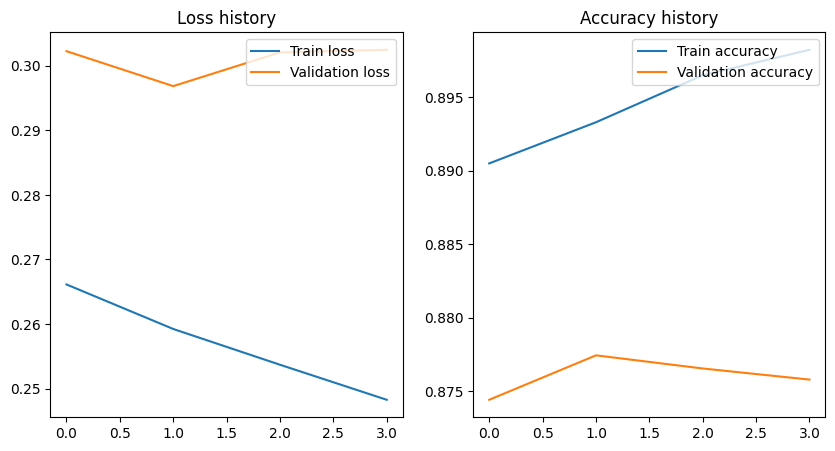

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss history')
ax[0].legend(['Train loss', 'Validation loss'],loc='upper right')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Accuracy history')
ax[1].legend(['Train accuracy', 'Validation accuracy'], loc='upper right')

plt.show()

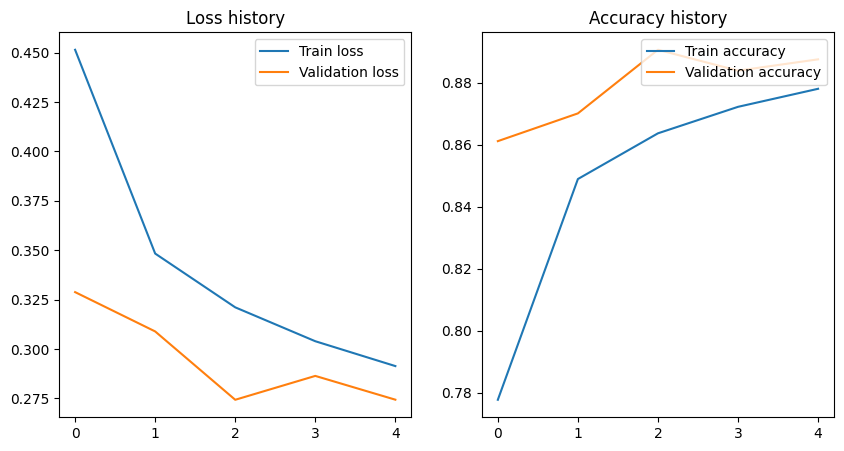

In [279]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss history')
ax[0].legend(['Train loss', 'Validation loss'],loc='upper right')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Accuracy history')
ax[1].legend(['Train accuracy', 'Validation accuracy'], loc='upper right')

plt.show()

In [66]:
poi_c2v.save_model('../../data/06_models/Conv-Sequential-mixed-sources-training-BEAT-EDIT-large')

In [137]:
model = poi_c2v.load_model('../../data/06_models/Conv-mixed-sources-training-BEAT-EDIT-large')

In [281]:
poi_c2v.model.summary()

Model: "model_82"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_branch_input (InputLayer)  [(None, 100, 1)]    0           []                               
                                                                                                  
 right_branch_input (InputLayer  [(None, 100, 1)]    0           []                               
 )                                                                                                
                                                                                                  
 model_81 (Functional)          (None, 2304)         1090584     ['left_branch_input[0][0]',      
                                                                  'right_branch_input[0][0]']     
                                                                                           

In [67]:
X_test_1 = encode_sparsed_list(X_test[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
X_test_2 = encode_sparsed_list(X_test[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

# X_train_1 = encode_sparsed_list(X_train[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
# X_train_2 = encode_sparsed_list(X_train[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

In [68]:
test_predictions = poi_c2v.model.predict((X_test_1, X_test_2))
# train_predictions = poi_c2v.model.predict((X_train_1, X_train_2))

1634/1634 [==============================] - 26s 16ms/step



(
    array([15396.,  4941.,  3701.,  2737.,  1782.,  1649.,  1589.,  2361.,
        4068., 14033.]),
    array([4.43668963e-33, 1.00000001e-01, 2.00000003e-01, 3.00000012e-01,
       4.00000006e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
       8.00000012e-01, 8.99999976e-01, 1.00000000e+00]),
    <BarContainer object of 10 artists>
)

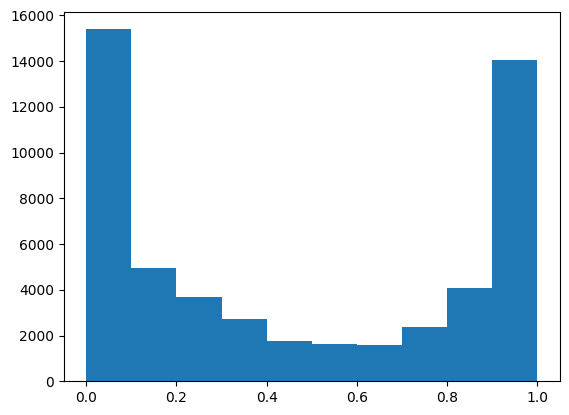

In [69]:
plt.hist(test_predictions)

In [70]:
pd.crosstab((y_test>=.75).flatten(), (test_predictions>=.5).flatten())

col_0,False,True
row_0,,
False,24256,2227
True,4301,21473


In [71]:
print(classification_report((y_test>=.5).flatten(), (test_predictions>=.5).flatten()))

              precision    recall  f1-score   support

       False       0.85      0.92      0.88     26483
        True       0.91      0.83      0.87     25774

    accuracy                           0.88     52257
   macro avg       0.88      0.87      0.87     52257
weighted avg       0.88      0.88      0.87     52257



In [55]:
from fuzzywuzzy import fuzz

In [56]:
token_set_predictions = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in X_test])
# token_set_predictions_train = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in X_train])

In [72]:
pd.crosstab((y_test>=.5).flatten(), token_set_predictions>.75)

col_0,False,True
row_0,,
False,25149,1334
True,5459,20315


In [73]:
print(classification_report((y_test>=.75).flatten(), token_set_predictions>.75))

              precision    recall  f1-score   support

       False       0.82      0.95      0.88     26483
        True       0.94      0.79      0.86     25774

    accuracy                           0.87     52257
   macro avg       0.88      0.87      0.87     52257
weighted avg       0.88      0.87      0.87     52257



In [74]:
results = pd.DataFrame(X_test)
results['prediction'] = test_predictions>=.5
results['token_set_ratio'] = token_set_predictions
results['label'] = y_test
results.columns = ['name_1', 'name_2', 'prediction','token_set_ratio', 'label']
results['prediction_error'] = results['prediction'] != results['label']
results['edit_error'] = (results['token_set_ratio']>.75) != results['label']

In [75]:
results_train = pd.DataFrame(X_train)
results_train['prediction'] = train_predictions
results_train['token_set_ratio'] = token_set_predictions_train
results_train['label'] = y_train
results_train.columns = ['name_1', 'name_2', 'prediction','token_set_ratio', 'label']
results_train['error'] = (results_train['prediction']>.5).astype(int) != results_train['label'].astype(int)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│                                                                                                  │
│   1 results_train = pd.DataFrame(X_train)                                                        │
│ ❱ 2 results_train['prediction'] = train_predictions                                              │
│   3 results_train['token_set_ratio'] = token_set_predictions_train                               │
│   4 results_train['label'] = y_train                                                             │
│   5 results_train.columns = ['name_1', 'name_2', 'prediction','token_set_ratio', 'label']        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'train_predictions' is not defined

In [77]:
results.to_csv('conv_results_sequential_test_mixed_sources.csv', index=False)
results_train.to_csv('conv_results_train_orbis.csv', index=False)

# 6. Prediciton

In [78]:
standard_1 = np.array(['dave smith',
                       'international business machine corp',
                       'bill gates',
                       'william h gates',
                       'mary miller',
                       'mary',
                       'ibm inc',
                       'ibm inc', 
                       'dave smith',
                       'royal free hospital',
                       'royal free hospital emergency room',
                       'royal free hospital school of medicine',
                       'howdens joinery',
                      'car craft'])
standard_2 = np.array(['david smith',
                       'ibm',
                       'william gates',
                       'william a gates',
                       'mark miller',
                       'mark',
                       'ibm corp',
                       'ibs inc',
                       'smith dave',
                       'royal free hospital emergency room',
                       'royal free hospital immunology',
                       'royal free hospital immunology',
                       'howdens new romney',
                      'carcraft and mot service centre'])
standard_target = np.array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1])
token_set_ratio = [fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in list(zip(standard_1, standard_2))]

In [79]:
standard_1_vectorized = encode_sparsed_list(standard_1,char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
standard_2_vectorized = encode_sparsed_list(standard_2,char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

In [80]:
standard_predictions = poi_c2v.model.predict((standard_1_vectorized, standard_2_vectorized))

1/1 [==============================] - 0s 37ms/step


In [81]:
pd.DataFrame(list(zip(standard_1, standard_2, standard_target, standard_predictions, token_set_ratio)))

,0,1,2,3,4
0,dave smith,david smith,1,[0.89375305],0.86
1,international business machine corp,ibm,1,[0.31713188],0.11
2,bill gates,william gates,1,[0.9194644],0.78
3,william h gates,william a gates,0,[0.99453497],0.93
4,mary miller,mark miller,0,[0.9648974],0.91
5,mary,mark,0,[0.28645465],0.75
6,ibm inc,ibm corp,1,[0.028367918],0.67
7,ibm inc,ibs inc,0,[0.0020040981],0.86
8,dave smith,smith dave,1,[0.3783289],1.00
9,royal free hospital,royal free hospital emergency room,0,[0.97466063],1.00


In [185]:
geonames_pairs = catalog.load('geonames_latin_pairs')
geonames_pairs = geonames_pairs.withColumn('target', when(col('match') == 'true', 1).otherwise(0).cast(FloatType()))
geonames_pairs_es = geonames_pairs.filter(col('language_1').isin(['ES', 'MX']))
geonames_normalized = geonames_pairs_es.withColumn('name_1_normalized', udf_normalize_chars(col('name_1'))) \
                .withColumn('name_2_normalized', udf_normalize_chars(col('name_2')))


name_pairs = geonames_normalized.select('name_1_normalized', 'name_2_normalized').toPandas().values
target = geonames_normalized.select(col('target')).toPandas().astype(float).values

X1 = encode_sparsed_list(name_pairs[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
X2 = encode_sparsed_list(name_pairs[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

[08/16/23 19:42:21] INFO     Loading data from 'geonames_latin_pairs' (SparkDataSet)...         ]8;id=676144;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=272117;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

In [809]:
geonames_predictions = poi_c2v.model.predict((X1, X2))

1708/1708 [==============================] - 19s 11ms/step



(
    array([13140.,  3133.,  1532.,  1076.,   925.,   897.,   964.,  1118.,
        1498., 30360.]),
    array([3.25981440e-04, 1.00292802e-01, 2.00259626e-01, 3.00226450e-01,
       4.00193274e-01, 5.00160098e-01, 6.00126922e-01, 7.00093746e-01,
       8.00060570e-01, 9.00027394e-01, 9.99994218e-01]),
    <BarContainer object of 10 artists>
)

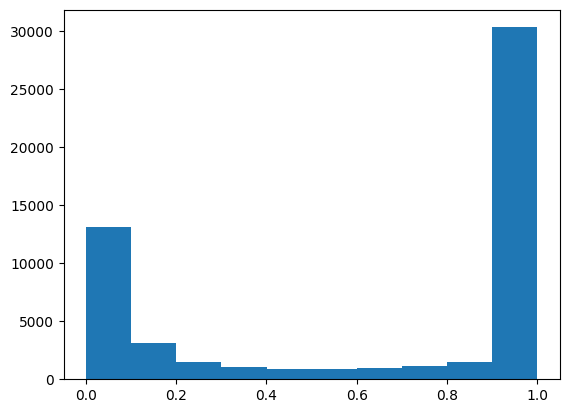

In [810]:
plt.hist(geonames_predictions)

In [811]:
pd.crosstab((target>=.75).flatten(), (geonames_predictions>=.5).flatten())

col_0,False,True
row_0,,
False,16004,11397
True,3802,23440


In [812]:
print(classification_report((target>=.5).flatten(), geonames_predictions>.5))

              precision    recall  f1-score   support

       False       0.81      0.58      0.68     27401
        True       0.67      0.86      0.76     27242

    accuracy                           0.72     54643
   macro avg       0.74      0.72      0.72     54643
weighted avg       0.74      0.72      0.72     54643



In [813]:
print(classification_report((target>=.5).flatten(), geonames_predictions>.5))

              precision    recall  f1-score   support

       False       0.81      0.58      0.68     27401
        True       0.67      0.86      0.76     27242

    accuracy                           0.72     54643
   macro avg       0.74      0.72      0.72     54643
weighted avg       0.74      0.72      0.72     54643



In [814]:

token_set_predictions = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in name_pairs])>.75
pd.crosstab((target>=.5).flatten(), token_set_predictions)

col_0,False,True
row_0,,
False,23164,4237
True,7350,19892


In [579]:
print(classification_report((target>=.5).flatten(), token_set_predictions))

              precision    recall  f1-score   support

       False       0.76      0.85      0.80     27401
        True       0.82      0.73      0.77     27242

    accuracy                           0.79     54643
   macro avg       0.79      0.79      0.79     54643
weighted avg       0.79      0.79      0.79     54643



# Match logs comparison

In [82]:
matching_logs = pd.read_csv('../../data/01_raw/tomtom/full_matching_logs_ES_EN_ov32.csv')

In [83]:
matching_logs.columns


Index(['release_version', 'enduser_category', 'category_id_tt',
       'category_name', 'reference_translated_cat_id', 'reference_id',
       'api_poi_id', 'providers_translated_cat_id', 'ref_lat', 'ref_lon',
       'location_distance_m', 'pav_threshold_distance_m',
       'pa_threshold_distance_m', 'name', 'api_poiName', 'name_ref_nrm',
       'name_prov_nrm', 'api_poiBrand', 'brand_flag', 'category_matching',
       'distance_matching', 'name_matching', 'match_code', 'match',
       'best_result', 'bool_pa', 'config_params', 'region', 'matching_run_id',
       'provider_id', 'country', 'sample_round'],
      dtype='object')

In [84]:
matching_names = matching_logs.copy()

In [85]:
matching_names['name'] = matching_names['name'].apply(lambda x: normalize_characters(x))
matching_names['api_poiName'] = matching_names['api_poiName'].apply(lambda x: normalize_characters(x))

In [86]:
matching_names = matching_names[(~matching_names['name_matching'].isnull()) & (matching_names['api_poiName']!= 'null') & (matching_names['match_code'] != 5)]

In [87]:
matching_names

,release_version,enduser_category,category_id_tt,category_name,reference_translated_cat_id,reference_id,api_poi_id,providers_translated_cat_id,ref_lat,ref_lon,...,match_code,match,best_result,bool_pa,config_params,region,matching_run_id,provider_id,country,sample_round
2,23320.000 OV,Automotive,9910,Automotive Dealer,9910,ChIJ3W8E5CrBz4URipUCDSXmFhA,3.393684e+10,7310.0,19.054592,-98.219340,...,2,False,True,NaN,NaN,NaN,20230814-06094864,om,MEX,cc
3,23320.000 OV,Eat & Drink,9376,Café/Pub,9376,ChIJ54VcVHuK2YURvKEcmE-C290,3.398599e+10,7315.0,20.945530,-97.389084,...,1,True,True,True,NaN,NaN,20230814-06094864,om,MEX,cc
5,23320.000 OV,Things to see & do,9357,Beach,9357,ChIJH7DqZYr414URTUf3jjOCJXw,1.021585e+10,9357.0,22.290174,-97.803566,...,1,True,True,False,NaN,NaN,20230814-06094864,om,MEX,cc
11,23320.000 OV,Eat & Drink,9376,Café/Pub,9376,ChIJVxwysZvELIQRpNPc9kU8Z_0,3.400459e+10,7315.0,20.213703,-100.882120,...,2,False,True,NaN,NaN,NaN,20230814-06094864,om,MEX,cc
12,23320.000 OV,Automotive,9910,Automotive Dealer,9910,ChIJX7BDM4DAK4QRkX7UT6vS8lw,3.395777e+10,9910.0,21.117882,-101.707825,...,1,True,True,True,NaN,NaN,20230814-06094864,om,MEX,cc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19518,23320.000 OV,Things to see & do,9362,Park and Recreation Area,9362,ChIJW-KdHvNGIYQRMqixIdx1U60,1.053229e+10,9362.0,20.714619,-105.274820,...,1,True,True,True,NaN,NaN,20230814-06094864,om,MEX,cc
19523,23320.000 OV,Amenities,7328,Bank,7328,ChIJ2aMAqttpNg0RVxngOC1-VWo,3.392415e+10,7328.0,43.358700,-5.506369,...,1,True,True,True,NaN,NaN,20230814-06094864,om,ESP,cc
19526,23320.000 OV,Lodging,7360,Camping Ground,7360,ChIJNwJYS9N9MQ0RR5FIbDmEiYs,3.398923e+10,7360.0,43.545910,-6.995946,...,1,True,True,True,NaN,NaN,20230814-06094864,om,ESP,cc
19532,23320.000 OV,Things to see & do,9357,Beach,9357,ChIJgyIbeDyruxIRKTnr1nkabJ0,7.324229e+09,8099.0,41.861630,3.150960,...,1,True,True,False,NaN,NaN,20230814-06094864,om,ESP,cc


In [88]:
matching_test_names = matching_names[['name', 'api_poiName']].values

In [89]:
matching_test_names_encoded_left = encode_sparsed_list(matching_test_names[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
matching_test_names_encoded_right = encode_sparsed_list(matching_test_names[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

In [90]:
matching_test_names_prediction = poi_c2v.model.predict((matching_test_names_encoded_left, matching_test_names_encoded_right))

323/323 [==============================] - 5s 16ms/step


In [91]:
matching_names['cnn_name_match_score'] = matching_test_names_prediction

In [92]:
matching_names['edit_distance_match'] = matching_names['name_matching']>=0.75
matching_names['cnn_match'] = matching_names['cnn_name_match_score']>=0.5

In [93]:
pd.crosstab(matching_names['edit_distance_match'], matching_names['cnn_match'])

cnn_match,False,True
edit_distance_match,,
False,191,17
True,1902,8203


In [218]:
matching_names[['category_name', 'name', 'api_poiName','api_poiBrand', 'name_ref_nrm', 'name_prov_nrm', 'location_distance_m', 'match','match_code', 'cnn_match', 'edit_distance_match', 'name_matching', 'cnn_name_match_score']].to_csv('name_matching_comparison_cnn_vs_edit.csv', index=False)


(
    array([  53.,   75.,  100.,   76.,   36.,   47.,  142.,  302.,  407.,
       9075.]),
    array([5.56590210e-04, 1.00500919e-01, 2.00445250e-01, 3.00389588e-01,
       4.00333911e-01, 5.00278234e-01, 6.00222588e-01, 7.00166881e-01,
       8.00111234e-01, 9.00055528e-01, 9.99999881e-01]),
    <BarContainer object of 10 artists>
)

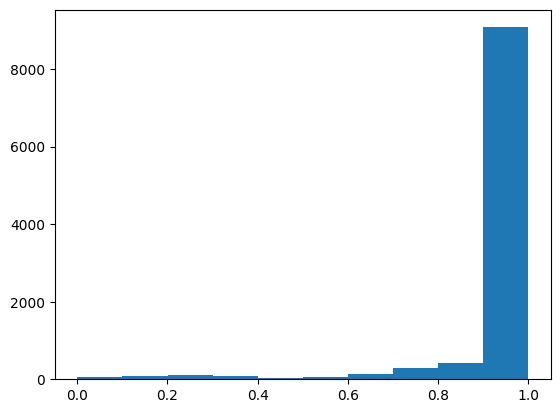

In [219]:
plt.hist(matching_test_names_prediction)

# Orbis data comparison

In [98]:
def generate_comparison_model_vs_edit(pairs, target, match_th, ):
    X_encoded_1 = encode_sparsed_list(pairs[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
    X_encoded_2 = encode_sparsed_list(pairs[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
    
    prediction = poi_c2v.model.predict((X_encoded_1, X_encoded_2))
    prediction_edit = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in pairs])
    
    y_pred = prediction>match_th
    y_pred = y_pred.flatten()
    y_pred_edit = prediction_edit>.75
    y_pred_edit = y_pred_edit.flatten()
    target = target.astype(np.bool).flatten()

    
    print('confussion matrix model')
    print(pd.crosstab(target, y_pred))
    print('\n confussion matrix edit')
    print(pd.crosstab(target, y_pred_edit))
    
    print('/n/n Classification report model')
    print(classification_report((target>=.5).flatten(), y_pred))
    print('/n Classification report edit')
    print(classification_report((target>=.5).flatten(), y_pred_edit))

In [220]:
generate_comparison_model_vs_edit(name_pairs_orbis, target_orbis, 0.5)

9964/9964 [==============================] - 142s 14ms/step


[08/21/23 14:02:59] WARNING  /tmp/ipykernel_883/1921957139.py:12: DeprecationWarning: `np.bool` is  ]8;id=99626;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=186299;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             a deprecated alias for the builtin `bool`. To silence this warning,                   
                             use `bool` by itself. Doing this will not modify any behavior and is                  
                             safe. If you specifically wanted the numpy scalar type, use `np.bool_`                
                             here.                                                                                 
                             Deprecated in NumPy 1.20; for more details and guidance:                              
                             https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations                      
                               target = target.astype(np.bool).flatten()                                           
                                                                                                                   

confussion matrix model
col_0   False   True 
row_0                
False  147848   11570
True     1939  157479

 confussion matrix edit
col_0   False   True 
row_0                
False  158831     587
True    12869  146549
/n/n Classification report model
              precision    recall  f1-score   support

       False       0.99      0.93      0.96    159418
        True       0.93      0.99      0.96    159418

    accuracy                           0.96    318836
   macro avg       0.96      0.96      0.96    318836
weighted avg       0.96      0.96      0.96    318836

/n Classification report edit
              precision    recall  f1-score   support

       False       0.93      1.00      0.96    159418
        True       1.00      0.92      0.96    159418

    accuracy                           0.96    318836
   macro avg       0.96      0.96      0.96    318836
weighted avg       0.96      0.96      0.96    318836



# Dataset gold standard

In [99]:
data_standard = pd.read_csv('../../data/02_intermediate/names/names.csv')

In [100]:
data_standard['name_1'] = data_standard['name_1'].apply(lambda x: normalize_characters(x))
data_standard['name_2'] = data_standard['name_2'].apply(lambda x: normalize_characters(x))

In [101]:
data_standard_pairs = data_standard[['name_1', 'name_2']].values
data_standard_target = data_standard['target'].values

In [102]:
generate_comparison_model_vs_edit(data_standard_pairs, data_standard_target, .5)

255/255 [==============================] - 4s 16ms/step


[08/22/23 15:31:16] WARNING  /tmp/ipykernel_6460/1921957139.py:12: DeprecationWarning: `np.bool` is ]8;id=942396;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=647066;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             a deprecated alias for the builtin `bool`. To silence this warning,                   
                             use `bool` by itself. Doing this will not modify any behavior and is                  
                             safe. If you specifically wanted the numpy scalar type, use `np.bool_`                
                             here.                                                                                 
                             Deprecated in NumPy 1.20; for more details and guidance:                              
                             https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations                      
                               target = target.astype(np.bool).flatten()                                           
                                                                                                                   

confussion matrix model
col_0  False  True 
row_0              
False   3485    382
True     230   4063

 confussion matrix edit
col_0  False  True 
row_0              
False   1673   2194
True     800   3493
/n/n Classification report model
              precision    recall  f1-score   support

       False       0.94      0.90      0.92      3867
        True       0.91      0.95      0.93      4293

    accuracy                           0.93      8160
   macro avg       0.93      0.92      0.92      8160
weighted avg       0.93      0.93      0.92      8160

/n Classification report edit
              precision    recall  f1-score   support

       False       0.68      0.43      0.53      3867
        True       0.61      0.81      0.70      4293

    accuracy                           0.63      8160
   macro avg       0.65      0.62      0.61      8160
weighted avg       0.64      0.63      0.62      8160



## Amazon products evaluation

In [103]:
data_prod= pd.read_csv('../../data/01_raw/amazon-google-products/mapping_full.csv')

In [104]:
data_prod['name_1'] = data_prod['name_1'].apply(lambda x: normalize_characters(x))
data_prod['name_2'] = data_prod['name_2'].apply(lambda x: normalize_characters(x))
data_prod['target'] = 1


In [105]:
data_prod_pairs = data_prod[['name_1', 'name_2']].values
data_prod_target = data_prod['target'].values

In [106]:
generate_comparison_model_vs_edit(data_prod_pairs, data_prod_target, .5)

41/41 [==============================] - 1s 16ms/step


[08/22/23 15:31:29] WARNING  /tmp/ipykernel_6460/1921957139.py:12: DeprecationWarning: `np.bool` is ]8;id=629154;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=24515;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             a deprecated alias for the builtin `bool`. To silence this warning,                   
                             use `bool` by itself. Doing this will not modify any behavior and is                  
                             safe. If you specifically wanted the numpy scalar type, use `np.bool_`                
                             here.                                                                                 
                             Deprecated in NumPy 1.20; for more details and guidance:                              
                             https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations                      
                               target = target.astype(np.bool).flatten()                                           
                                                                                                                   

confussion matrix model
col_0  False  True 
row_0              
True     582    718

 confussion matrix edit
col_0  False  True 
row_0              
True     212   1088
/n/n Classification report model


                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=648673;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=106238;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=293010;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=485611;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=15805;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=386769;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.55      0.71      1300

    accuracy                           0.55      1300
   macro avg       0.50      0.28      0.36      1300
weighted avg       1.00      0.55      0.71      1300

/n Classification report edit


                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=35087;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=913175;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=376530;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=714905;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=306129;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=148822;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.84      0.91      1300

    accuracy                           0.84      1300
   macro avg       0.50      0.42      0.46      1300
weighted avg       1.00      0.84      0.91      1300



# ABT vs BUY products evaluation

In [107]:
data_prod_abt = pd.read_csv('../../data/01_raw/abt-buy-dataset/abt_buy_perfectMapping_full.csv')

In [108]:
data_prod_abt['name_1'] = data_prod_abt['name_1'].apply(lambda x: normalize_characters(x))
data_prod_abt['name_2'] = data_prod_abt['name_2'].apply(lambda x: normalize_characters(x))
data_prod_abt['target'] = 1

In [109]:
data_prod_abt_pairs = data_prod_abt[['name_1', 'name_2']].values
data_prod_abt_target = data_prod_abt['target'].values

In [110]:
data_prod_abt_pairs


array([['linksys etherfast 8 port 10 100 switch ezxs88w',
        'linksys etherfast ezxs88w ethernet switch ezxs88w'],
       ['linksys etherfast10 100 5 port auto sensing switch ezxs55w',
        'linksys etherfast ezxs55w ethernet switch'],
       ['netgear prosafe 5 port 10 100 desktop switch fs105',
        'netgear prosafe fs105 ethernet switch fs105na'],
       ...,
       ['sony lcs twa b black soft leather carrying case lcstwab',
        'sony lcs twa b cyber shot camera case lcstwa b'],
       ['sony white cybershot t series digital camera jacket case with stylus lcjthcw',
        'sony lcj thc b jacket case with stylus lcj thc w'],
       ['sony lcs csj black soft carrying case lcscsj',
        'sony lcs csj soft camera case lcscsj']], dtype=object)

In [111]:
generate_comparison_model_vs_edit(data_prod_abt_pairs, data_prod_abt_target, .5)

35/35 [==============================] - 1s 16ms/step


[08/22/23 15:31:37] WARNING  /tmp/ipykernel_6460/1921957139.py:12: DeprecationWarning: `np.bool` is ]8;id=394126;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=425997;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             a deprecated alias for the builtin `bool`. To silence this warning,                   
                             use `bool` by itself. Doing this will not modify any behavior and is                  
                             safe. If you specifically wanted the numpy scalar type, use `np.bool_`                
                             here.                                                                                 
                             Deprecated in NumPy 1.20; for more details and guidance:                              
                             https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations                      
                               target = target.astype(np.bool).flatten()                                           
                                                                                                                   

confussion matrix model
col_0  False  True 
row_0              
True     386    711

 confussion matrix edit
col_0  False  True 
row_0              
True     347    750
/n/n Classification report model


                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=702660;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=877847;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=461843;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=944240;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=815552;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=528153;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.65      0.79      1097

    accuracy                           0.65      1097
   macro avg       0.50      0.32      0.39      1097
weighted avg       1.00      0.65      0.79      1097

/n Classification report edit


                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=170724;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=822780;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=483385;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=803066;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=826381;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=989023;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.68      0.81      1097

    accuracy                           0.68      1097
   macro avg       0.50      0.34      0.41      1097
weighted avg       1.00      0.68      0.81      1097



# Affiliations dataset

In [112]:
raw_names = pd.read_csv('../../data/01_raw/affiliations/affiliationstrings_ids.csv')
mapping = pd.read_csv('../../data/01_raw/affiliations/affiliationstrings_mapping.csv').astype('int')

In [113]:
mapping.columns = ['id1', 'id2']
raw_names.columns = ['id', 'name']

In [114]:
data_affiliations = mapping.merge(raw_names, left_on='id1', right_on='id').merge(raw_names, left_on='id2', right_on='id')

In [115]:
data_affiliations['name_x'] = data_affiliations['name_x'].apply(lambda x: normalize_characters(x))
data_affiliations['name_y'] = data_affiliations['name_y'].apply(lambda x: normalize_characters(x))
data_affiliations['target'] = 1

In [116]:
data_affiliations = data_affiliations.drop_duplicates(subset=['name_x', 'name_y'])

In [117]:
data_affiliations_pairs = data_affiliations[['name_x', 'name_y']].values
data_affiliations_target = data_affiliations['target'].values

In [118]:
X_encoded_1 = encode_sparsed_list(data_affiliations_pairs[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
X_encoded_2 = encode_sparsed_list(data_affiliations_pairs[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
    
prediction = poi_c2v.model.predict((X_encoded_1, X_encoded_2))

863/863 [==============================] - 14s 16ms/step


In [119]:
prediction_token_set = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in data_affiliations_pairs])

In [120]:
data_affiliations['cnn_prediction'] = prediction.flatten()
data_affiliations['token_set_prediction'] = prediction_token_set

data_affiliations['cnn_match'] = prediction>.5
data_affiliations['token_set_match'] = prediction_token_set>.75

In [121]:
data_affiliations.to_csv('affiliations_cnn_vs_edit_predictions.csv', index=False)

In [122]:
generate_comparison_model_vs_edit(data_affiliations_pairs, data_affiliations_target, .5)

863/863 [==============================] - 14s 16ms/step


[08/22/23 15:32:26] WARNING  /tmp/ipykernel_6460/1921957139.py:12: DeprecationWarning: `np.bool` is ]8;id=626244;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=669647;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             a deprecated alias for the builtin `bool`. To silence this warning,                   
                             use `bool` by itself. Doing this will not modify any behavior and is                  
                             safe. If you specifically wanted the numpy scalar type, use `np.bool_`                
                             here.                                                                                 
                             Deprecated in NumPy 1.20; for more details and guidance:                              
                             https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations                      
                               target = target.astype(np.bool).flatten()                                           
                                                                                                                   

confussion matrix model
col_0  False  True 
row_0              
True   14663  12953

 confussion matrix edit
col_0  False  True 
row_0              
True    8030  19586
/n/n Classification report model


                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=316653;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=655814;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=450995;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=79735;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=129278;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=572034;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.47      0.64     27616

    accuracy                           0.47     27616
   macro avg       0.50      0.23      0.32     27616
weighted avg       1.00      0.47      0.64     27616

/n Classification report edit


                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=289784;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=100414;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=102279;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=907932;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=712795;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=586357;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.71      0.83     27616

    accuracy                           0.71     27616
   macro avg       0.50      0.35      0.41     27616
weighted avg       1.00      0.71      0.83     27616



# Voters North Carolina

In [1106]:
voters_raw_1 = pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_1000000_modrec_2_ocp_20_myp_0_nump_5.csv')
voters_raw_2 = pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_1000000_modrec_2_ocp_20_myp_1_nump_5.csv')
voters_raw_3 = pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_1000000_modrec_2_ocp_20_myp_2_nump_5.csv')
voters_raw_4 = pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_1000000_modrec_2_ocp_20_myp_3_nump_5.csv')
voters_raw_5 = pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_1000000_modrec_2_ocp_20_myp_4_nump_5.csv')

[08/15/23 20:44:56] WARNING  /tmp/ipykernel_26880/3995391869.py:1: DtypeWarning: Columns (4) have   ]8;id=863690;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=364802;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             mixed types. Specify dtype option on import or set low_memory=False.                  
                               voters_raw_1 =                                                                      
                             pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_10000                
                             00_modrec_2_ocp_20_myp_0_nump_5.csv')                                                 
                                                                                                                   

                    WARNING  /tmp/ipykernel_26880/3995391869.py:2: DtypeWarning: Columns (4) have   ]8;id=597558;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=764248;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             mixed types. Specify dtype option on import or set low_memory=False.                  
                               voters_raw_2 =                                                                      
                             pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_10000                
                             00_modrec_2_ocp_20_myp_1_nump_5.csv')                                                 
                                                                                                                   

[08/15/23 20:44:57] WARNING  /tmp/ipykernel_26880/3995391869.py:3: DtypeWarning: Columns (4) have   ]8;id=135609;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=84305;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             mixed types. Specify dtype option on import or set low_memory=False.                  
                               voters_raw_3 =                                                                      
                             pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_10000                
                             00_modrec_2_ocp_20_myp_2_nump_5.csv')                                                 
                                                                                                                   

                    WARNING  /tmp/ipykernel_26880/3995391869.py:4: DtypeWarning: Columns (4) have   ]8;id=99010;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=610317;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             mixed types. Specify dtype option on import or set low_memory=False.                  
                               voters_raw_4 =                                                                      
                             pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_10000                
                             00_modrec_2_ocp_20_myp_3_nump_5.csv')                                                 
                                                                                                                   

[08/15/23 20:44:58] WARNING  /tmp/ipykernel_26880/3995391869.py:5: DtypeWarning: Columns (4) have   ]8;id=189391;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=269717;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             mixed types. Specify dtype option on import or set low_memory=False.                  
                               voters_raw_5 =                                                                      
                             pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_10000                
                             00_modrec_2_ocp_20_myp_4_nump_5.csv')                                                 
                                                                                                                   

In [1121]:
voters_raw_full = pd.concat([voters_raw_1, voters_raw_2, voters_raw_3, voters_raw_4, voters_raw_5])

In [1133]:
voters_raw_full[voters_raw_full.recid == 58253]

,recid,givenname,surname,suburb,postcode
848117,58253,dullie,moss,charlotte,28269.0


In [1132]:
voters_raw_full[voters_raw_full.recid == 185780]

,recid,givenname,surname,suburb,postcode
88045,185780,ida,watts,carrboro,27510


In [1115]:
voters_raw_full.recid.value_counts()[voters_raw_full.recid.value_counts() == 2]


4829629    2
1802971    2
1615979    2
8026477    2
536452     2
          ..
5237754    2
4857586    2
1667198    2
3782787    2
893276     2
Name: recid, Length: 83904, dtype: int64

In [1102]:
voters_raw_1['name'] = voters_raw_1['givenname'] + ' ' + voters_raw_1['surname']
voters_raw_2['name'] = voters_raw_2['givenname'] + ' ' + voters_raw_2['surname']
voters_raw_3['name'] = voters_raw_3['givenname'] + ' ' + voters_raw_3['surname']


In [1105]:
voters_raw_1.merge(voters_raw_2, on='recid', how='left').merge(voters_raw_3, on='recid', how='left').dropna()

,recid,givenname_x,surname_x,suburb_x,postcode_x,name_x,givenname_y,surname_y,suburb_y,postcode_y,name_y,givenname,surname,suburb,postcode,name
1,3138435,ronel,carter,washington,2788g,ronel carter,ronnel,carter,washington,27889.0,ronnel carter,ronnel,carter,washington,27889.0,ronnel carter
2,6117295,jason,roehrig,millers ceeek,286s1,jason roehrig,jason,roehrig,millers creek,28651.0,jason roehrig,jason,roehrig,millers creek,28651.0,jason roehrig
3,6401695,antrea,mure,greensboro,27410,antrea mure,andrea,moore,greensboro,27410.0,andrea moore,andrea,moore,greensboro,27410.0,andrea moore
5,4338459,jonn,snyder,louisbuahg,27549,jonn snyder,john,snyddr,louisburg,27s49,john snyddr,zohn,snyder,louiburg,27549,zohn snyder
6,795481,charie,lyles,sdate road,28676,charie lyles,charlie,lyles,state road,28676.0,charlie lyles,charlie,lyles,state road,28676.0,charlie lyles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999985,5819868,meagan,pruitt,roxboro,27574.0,meagan pruitt,meagsn,pruiatt,roxboro,27574,meagsn pruiatt,mesgan,pruitt,roxboro,2757q,mesgan pruitt
999989,6680655,justin,pence,greensboro,27407.0,justin pence,justin,pence,greensboro,27407.0,justin pence,justin,pence,greensboro,27407.0,justin pence
999991,517540,roger,fristoe,greensboro,27408.0,roger fristoe,rojyr,fristoe,greensnoro,27408,rojyr fristoe,roger,fristoe,greensboro,27408.0,roger fristoe
999995,6614741,virginia,angle,charlotte,28205.0,virginia angle,virginia,angle,charlotte,28205.0,virginia angle,virginia,angle,charlotte,28205.0,virginia angle


# Embedding analysis

In [148]:

poi_c2v = poiNames_C2V(150, char_to_index)
poi_c2v = poi_c2v.load_model('../../data/06_models/Conv-mixed-sources-training-BEAT-EDIT')

In [160]:
test_names = ['ibm', 'international business machines']

In [161]:
X = encode_sparsed_list(test_names,char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

In [163]:
test_names

['ibm', 'international business machines']

In [162]:
print(X)

[[20. 13. 24.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [20. 25. 31. 16. 29. 25. 12. 31. 20. 26. 25. 12. 23.  1. 13. 32. 30. 20.
  25. 16. 30. 30.  1. 24. 12. 14. 19. 20. 25. 16. 30.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


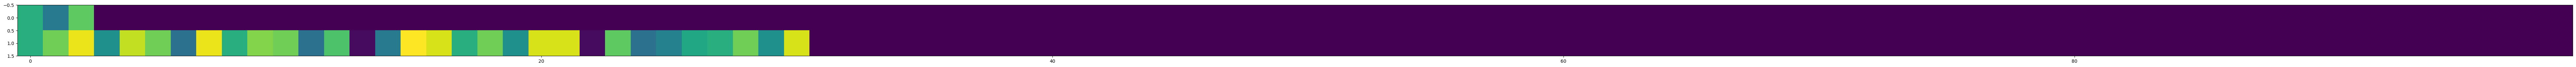

In [164]:
plt.figure(figsize=(100,100))
plt.imshow(X[:2])

1/1 [==============================] - 0s 26ms/step


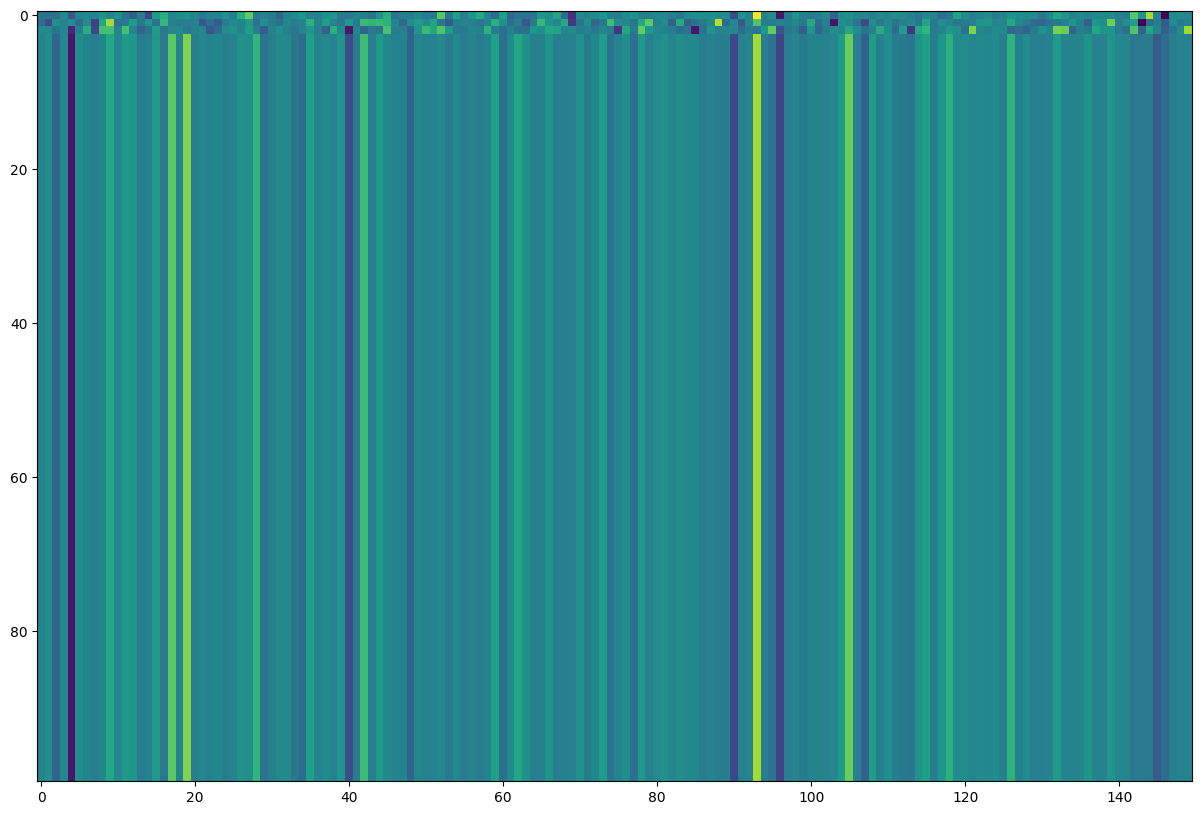

In [165]:
plt.figure(figsize=(100,10))
plt.imshow(poi_c2v.embedding_layer.predict(X[0:1]).reshape(-1,150))

4/4 [==============================] - 0s 2ms/step


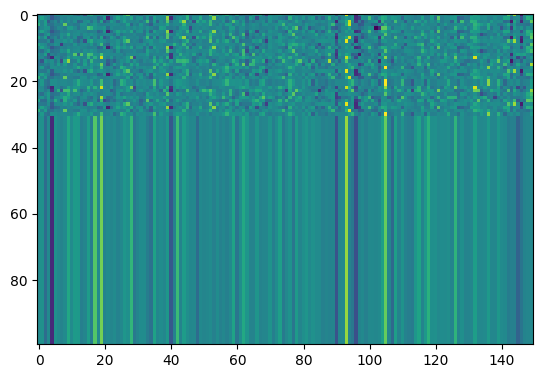

In [166]:
plt.imshow(poi_c2v.embedding_layer.predict(X[1]).reshape(-1,150))

In [171]:
fuzz.token_set_ratio('Car Craft', 'Carcraft Mot & Service Centre')

44

# Test layers

In [176]:
input_sequence = tf.keras.layers.Input(shape=100, name='input_sequence')
x = tf.keras.layers.Masking(mask_value=0)(input_sequence)
x = tf.keras.layers.Embedding(input_dim=100, output_dim=150, mask_zero=True)(x)
embedding_layer = tf.keras.models.Model(inputs=[input_sequence], outputs=x)

In [178]:
tf.keras.layers.Masking(mask_value=0)(X)


<tf.Tensor: shape=(2, 100), dtype=float32, numpy=
array([[20., 13., 24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [20., 25., 31., 16., 29., 25., 12., 31., 20., 26., 25., 12., 23.,
         1., 13., 32., 30., 20., 25., 16., 30., 30.,  1., 24., 12., 14.,
        19., 20., 25., 16., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  

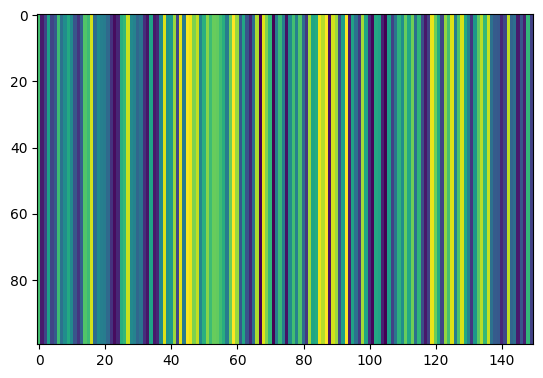

In [53]:
plt.imshow(embedding_layer(ones))